Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 74s 16s/step - accuracy: 0.6170 - loss: 0.6851 - val_accuracy: 0.5448 - val_loss: 0.7071
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 15s/step - accuracy: 0.6273 - loss: 0.6593 - val_accuracy: 0.5448 - val_loss: 0.7080
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 57s 14s/step - accuracy: 0.6173 - loss: 0.6603 - val_accuracy: 0.5448 - val_loss: 0.7101
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 16s/step - accuracy: 0.6200 - loss: 0.6629 - val_accuracy: 0.5448 - val_loss: 0.7116
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 56s 14s/step - accuracy: 0.6224 - loss: 0.6587 - val_accuracy: 0.5448 - val_loss: 0.7108
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6025 - loss: 0.6838
Test Loss: 0.6838322877883911, Test Accuracy: 0.6024757623672485


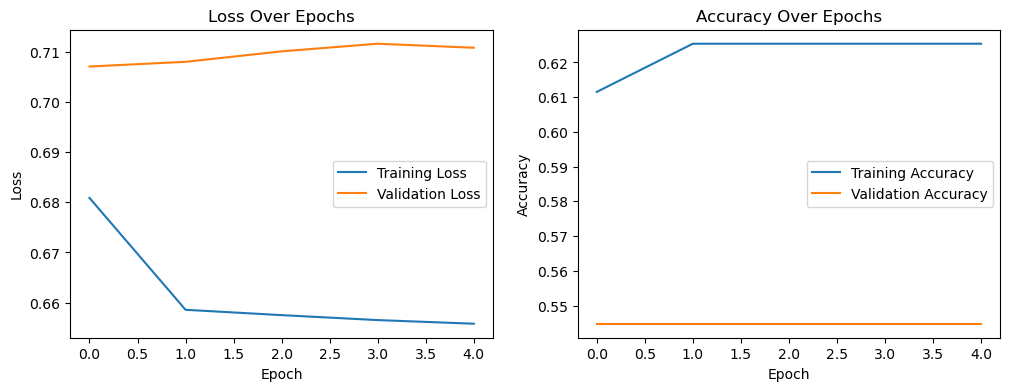

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


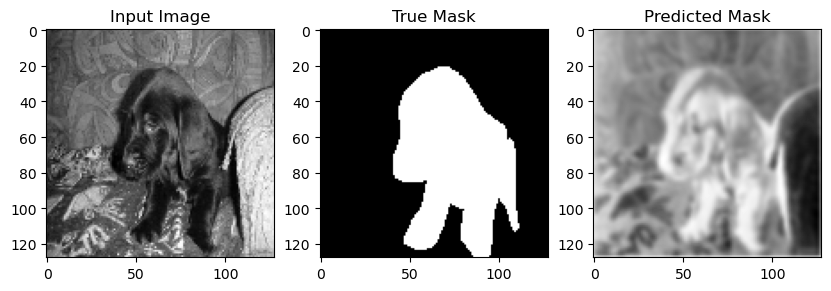

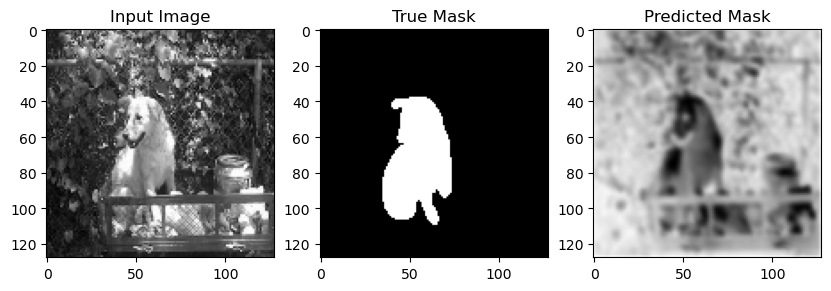

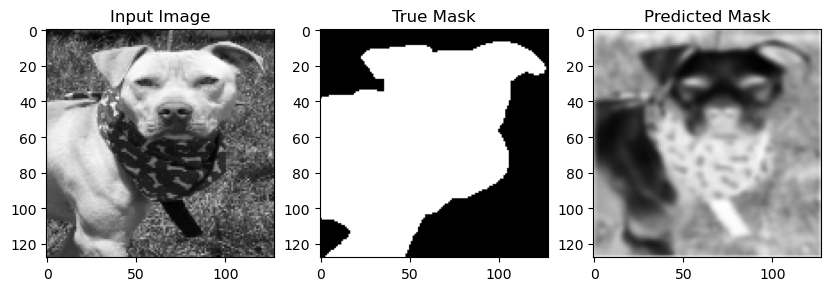

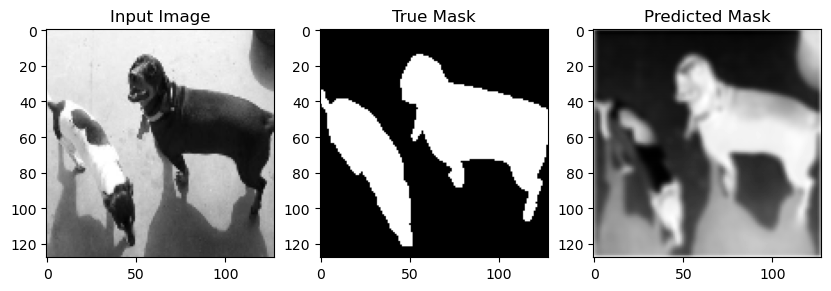

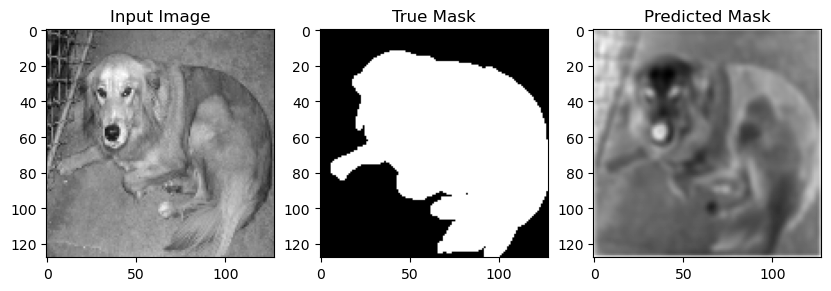

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

# Function to load images and corresponding labels (masks)
def load_imgs(img_folder_path, label_folder_path, img_size=(128, 128)):
    imgs = []
    labels = []
    
    img_files = sorted([f for f in os.listdir(img_folder_path) if f.endswith('.jpg')])
    label_files = sorted([f for f in os.listdir(label_folder_path) if f.endswith('.jpg')])

    # Ensure images and labels have the same number
    assert len(img_files) == len(label_files), f"Image count {len(img_files)} doesn't match label count {len(label_files)}"
    
    for img_file, label_file in zip(img_files, label_files):
        # Load image
        img = cv2.imread(os.path.join(img_folder_path, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            imgs.append(img)
            
            # Load corresponding label (mask)
            label = cv2.imread(os.path.join(label_folder_path, label_file), cv2.IMREAD_GRAYSCALE)
            if label is not None:
                label = cv2.resize(label, img_size, interpolation=cv2.INTER_NEAREST)  # Use nearest for mask resizing
                
                # Convert label to binary format for binary segmentation
                label = (label > 0).astype(np.float32)  # Ensure the label is binary (0 or 1)
                labels.append(label)
    
    return np.array(imgs), np.array(labels)


dog_img_path = r"C:\Users\Laptop\Desktop\CV\Pothole detection\semantic segmentation\Images"
dog_label_path = r"C:\Users\Laptop\Desktop\CV\Pothole detection\semantic segmentation\Labels"  


dog_images, dog_labels = load_imgs(dog_img_path, dog_label_path)

# Normalize the images and labels
dog_images = dog_images.astype('float32') / 255.0
dog_images = np.expand_dims(dog_images, -1)  # Shape to (num_samples, 128, 128, 1)

dog_labels = np.expand_dims(dog_labels, -1)  # Shape to (num_samples, 128, 128, 1)


x_train, x_temp, y_train, y_temp = train_test_split(dog_images, dog_labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    return model

input_shape = (128, 128, 1)
model = unet_model(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=32)

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

def visualize_predictions(model, x, y_true, num_samples=5):
    predictions = model.predict(x)
    for i in range(num_samples):
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        plt.title('Input Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        
        plt.show()

visualize_predictions(model, x_test, y_test)


In [ ]:
# Step-by-Step Explanation of the Code:

# 1. **Imports**:
# - **os**: Used for file path operations and reading file directories.
# - **numpy**: For numerical operations, especially in handling image data as arrays.
# - **tensorflow (tf)**: Deep learning library used to build, train, and evaluate the model.
# - **cv2 (OpenCV)**: Used for image processing tasks like reading, resizing, and manipulating images.
# - **matplotlib.pyplot**: Used for plotting training history and predictions.
# - **train_test_split**: From `sklearn`, used to split the data into training, validation, and test sets.

# 2. **Image and Mask Loading Function**:
# - **Purpose**: Loads images and their corresponding mask labels (used for segmentation) from specified directories.
# - **Steps**:
#   - Filters `.jpg` files from the directories.
#   - Ensures that the number of images matches the number of labels.
#   - Loads the images as grayscale (`cv2.IMREAD_GRAYSCALE`) and resizes them to the specified `img_size`.
#   - The labels (masks) are resized using nearest neighbor interpolation for consistency, and then converted to binary format (0 or 1).

# 3. **Loading and Normalizing Data**:
# - **Purpose**: Loads the image data and normalizes it.
#   - Images are converted to the `float32` type and normalized to the range `[0, 1]`.
#   - The dimensions of both the images and labels are expanded to include a channel dimension (`128, 128, 1`).

# 4. **Train-Validation-Test Split**:
# - **Purpose**: Splits the dataset into training, validation, and test sets using `train_test_split` from `sklearn`.

# 5. **U-Net Model Architecture**:
# - **U-Net**: A popular deep learning architecture for **semantic segmentation**. It uses an encoder-decoder structure.
#   - **Encoder**: Extracts features from the input image using convolutional layers. Each convolution is followed by a max-pooling layer to down-sample the feature maps.
#   - **Bottleneck**: A deep layer where the network captures high-level features.
#   - **Decoder**: Upscales the feature maps back to the original image size. Convolutional layers and transposed convolutions (upsampling) are used to reconstruct the output segmentation mask.
#   - **Skip Connections**: These connect corresponding layers from the encoder and decoder, allowing the decoder to access fine-grained spatial information.

# 6. **Compiling the Model**:
# - **Optimizer**: Uses the Adam optimizer, which adapts the learning rate during training for efficient learning.
# - **Loss**: The loss function is `binary_crossentropy`, suitable for binary segmentation tasks (background vs. object).
# - **Metrics**: Accuracy is tracked during training.

# 7. **Model Training**:
# - **Purpose**: Trains the U-Net model on the training data for 5 epochs, with validation on the validation set.

# 8. **Model Evaluation**:
# - **Purpose**: Evaluates the model on the test data and prints the loss and accuracy.

# 9. **Plotting the Training History**:
# - **Purpose**: Plots the training and validation loss over the epochs to analyze the model's learning process.

# 10. **Visualizing Predictions**:
# - **Purpose**: Visualizes a set of predictions along with their corresponding input images and true masks.

---

# **U-Net Architecture Explanation (Theoretical)**:
# - **U-Net** is a **convolutional neural network (CNN)** designed for semantic segmentation. It is widely used in medical image segmentation and other tasks requiring pixel-wise classification.
# - **Structure**:
#   - **Contracting Path (Encoder)**: A series of convolutional layers that reduce spatial dimensions while increasing feature depth. This part extracts important features from the input image.
#   - **Bottleneck**: The deepest part of the network where the image is represented in the smallest spatial dimension but with the most complex feature set.
#   - **Expansive Path (Decoder)**: Uses transposed convolutions to upsample and bring the feature maps back to the original image size, with skip connections that pass features from the encoder layers.
#   - **Skip Connections**: They are crucial for retaining high-resolution features and allow the decoder to recover fine-grained spatial information.
# - **Output**: The final output is a segmentation mask of the same size as the input image, where each pixel is classified into one of the classes (e.g., object vs. background).

---

# **Practical Exam Questions and Answers**:

# 1. **What is the role of the `MaxPooling2D` layer in the U-Net architecture?**
# - **Answer**: The `MaxPooling2D` layer performs down-sampling by reducing the spatial dimensions of the feature maps. It helps the network to capture spatial hierarchies and retain important features while reducing computational complexity.

# 2. **Why is `binary_crossentropy` used as the loss function in this semantic segmentation task?**
# - **Answer**: `binary_crossentropy` is used because this is a binary classification problem for each pixel—either the pixel belongs to the object or the background.

# 3. **What are the advantages of skip connections in U-Net?**
# - **Answer**: Skip connections help preserve spatial information lost during down-sampling in the encoder. They improve the accuracy of segmentation by combining low-level spatial information with high-level features.

